In [98]:
import pickle
from math import floor
from IPython.display import display, clear_output
import scipy.stats
from pylab import * 
import numpy as np
import seaborn as sns
import pandas
from itertools import product as iterproduct
%matplotlib inline
%run "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/analysis_lib.ipynb"
sns.set_style("ticks", {"axes.grid" : True, "grid.color" : ".95"})
matplotlib.rcParams.update({'font.size': 16})

In [38]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
}

# args = {
#     "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_alignment_true_events.pickle",
#     "ref": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/lambda_ref.fasta",
# }

In [39]:
NMER = 3

In [40]:
!pwd

/home/ibis/gregor.sturm/nanopore/own/notebooks/04_error_correction


In [41]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [42]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>mmusMT_PCR1']
GTTAATGTAGCTTAATAACAAAGCAAAGCACTGAAAATGCTTAGATGGATAATTGTATCCCATAAACACAAAGGTTTGGTCCTGGCCTTATAATTAATTA


In [43]:
def get_context(event, start, end):
    """get the nt-context around the kmer. 
    E.g. start=-20: get context 20nt before the reference point
    (mid of kmer)"""
    ref_pos = event["ref_position"]
    start = ref_pos + start
    end = ref_pos + end
    return ref[start:end]

def get_context_before(event, n):
    """get n nucleotides before the start of the kmer"""
    length = len(event["kmer"])
    offset = int(-floor(length/2))
    return get_context(event, -n+offset, offset)
    
def get_context_after(event, n):
    length = len(event["kmer"])
    offset = int(floor(length/2) + 1)
    return get_context(event, offset, offset+n)

In [44]:
test_event = true_events[0]
assert test_event['kmer'] == get_context(test_event, -2, 2+1), "invalid reference"
assert (get_context_before(test_event, 20) 
        + test_event['kmer'] 
        + get_context_after(test_event, 20)) == (
    get_context(test_event, -22, 22+1))

## Analysis 

In [45]:
all_5mers = mk_kmer_dict(NMER)
ev_map = mk_event_map(true_events, all_5mers)

In [169]:
template_events = [ev for ev in ev_map["ATG"] if not np.isnan(ev["template.mean"])]
means = [ev["template.mean"] for ev in template_events]
stdvs = [ev["template.stdv"] for ev in template_events]
context_before = [get_context_before(ev, 200) for ev in template_events]
context_after = [get_context_after(ev, 200) for ev in template_events]

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


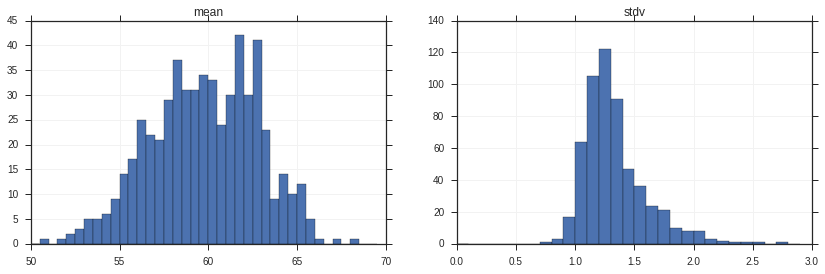

In [170]:
fig, (ax1, ax2) = subplots(1, 2, figsize=(14,4))
ax1.hist(means, bins=np.arange(50, 70, .5))
ax1.set_title("mean")
ax2.hist(stdvs, bins=np.arange(0, 3, .1))
ax2.set_title("stdv")
fig.show()

In [171]:
def nt_dict(nts, values):     
    d = OrderedDict(((nt, []) for nt in NT_RMAP.values()))
    for nt, val in zip(nts, values): 
        d[NT_RMAP[nt]].append(val)
    return d

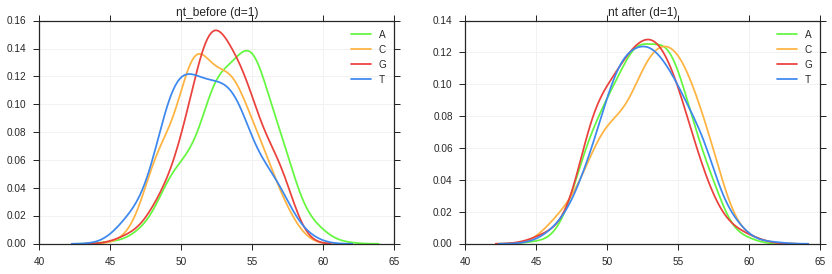

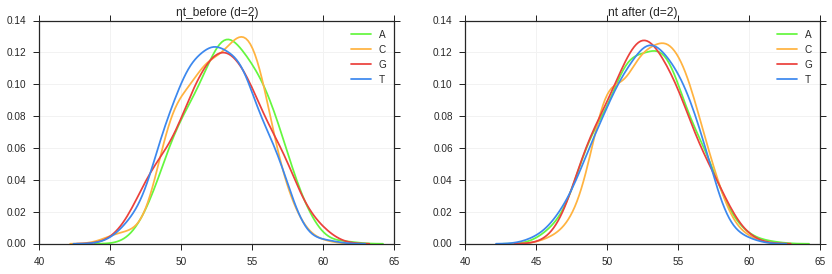

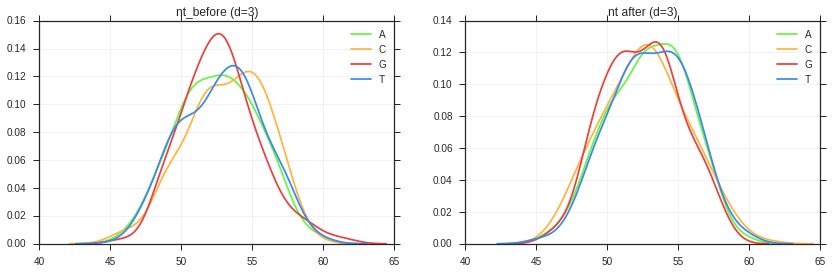

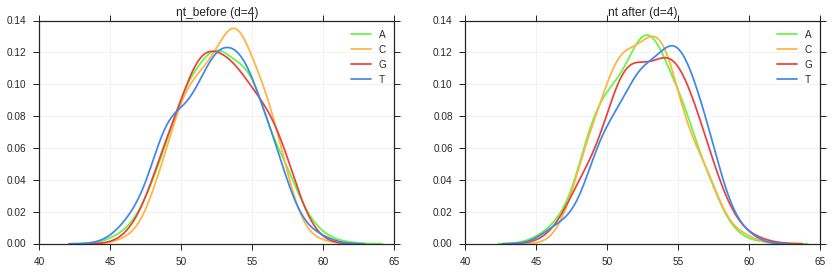

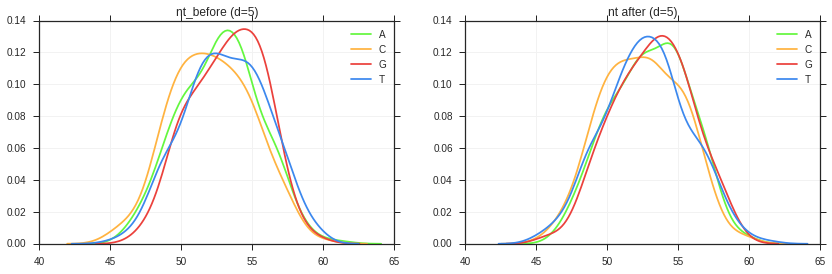

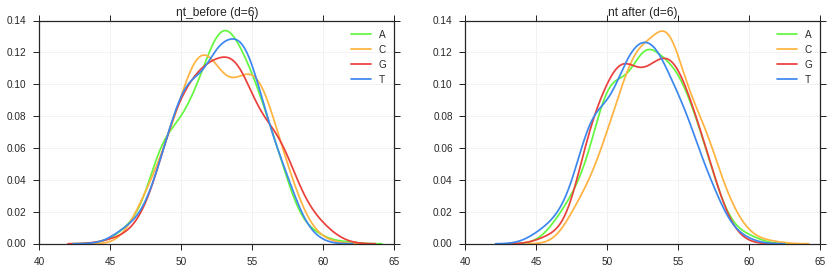

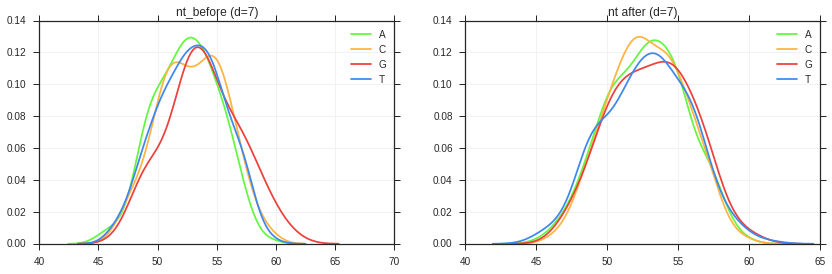

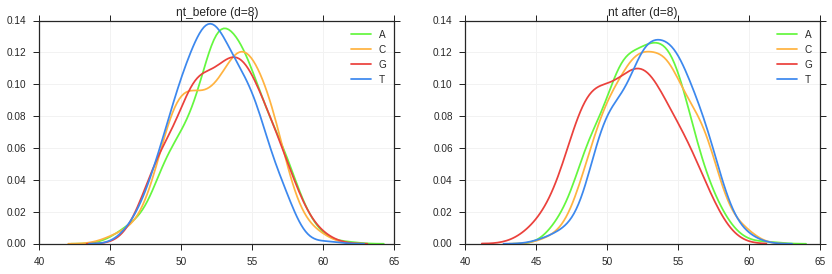

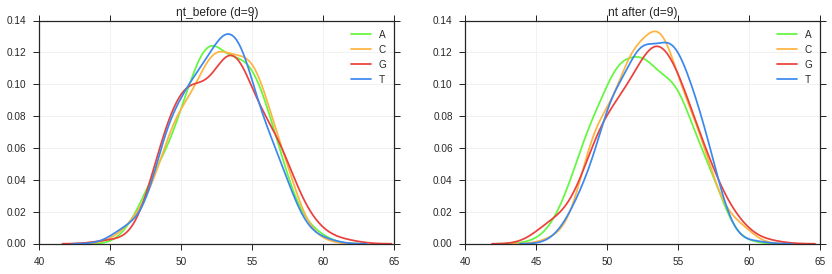

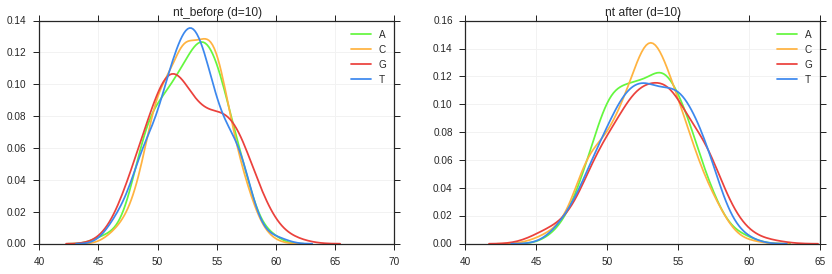

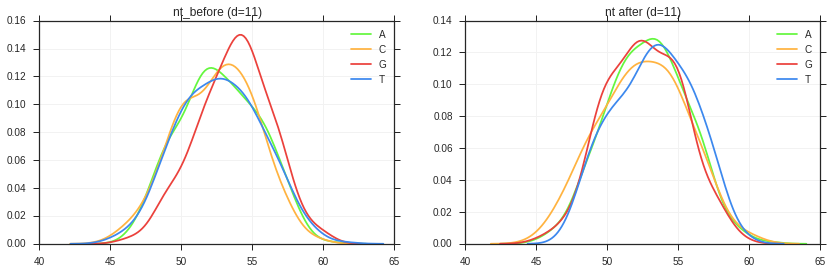

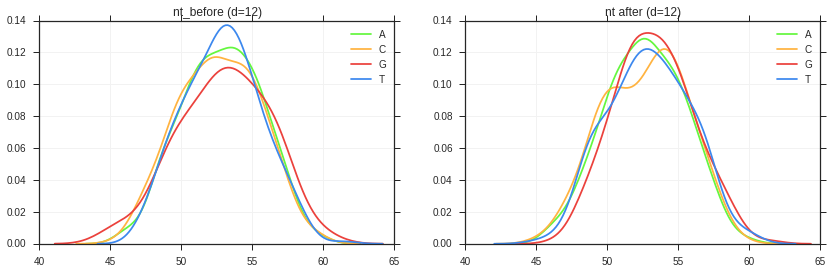

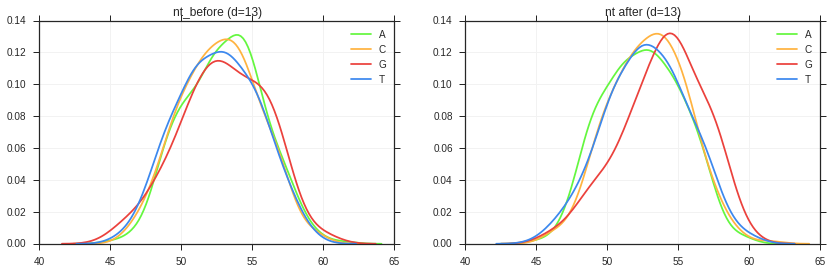

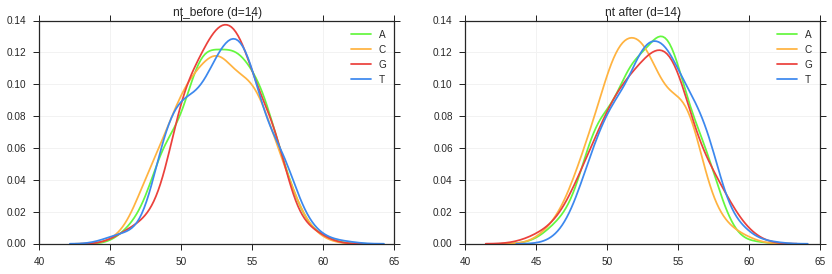

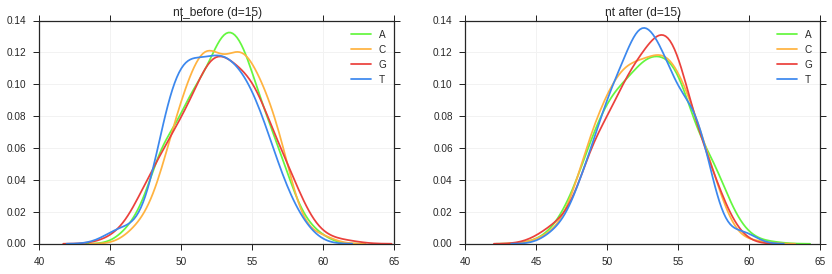

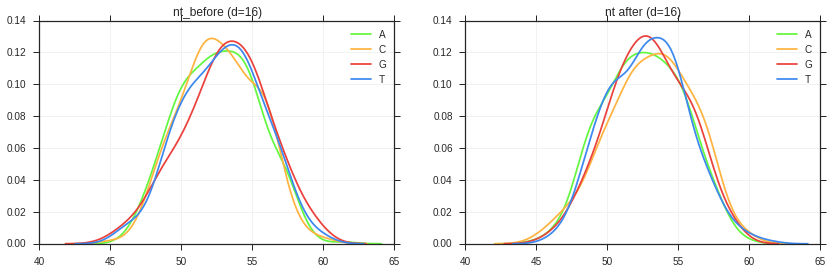

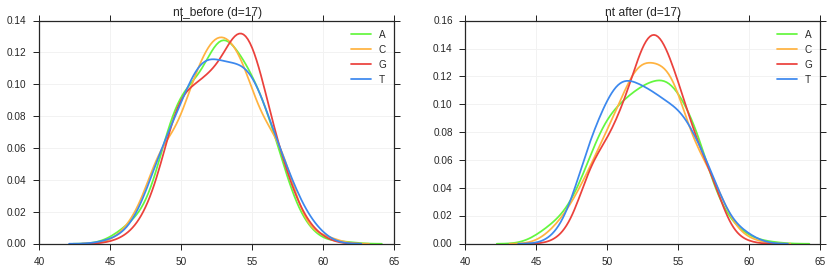

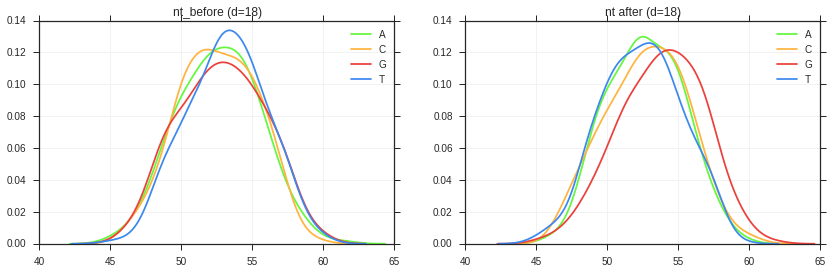

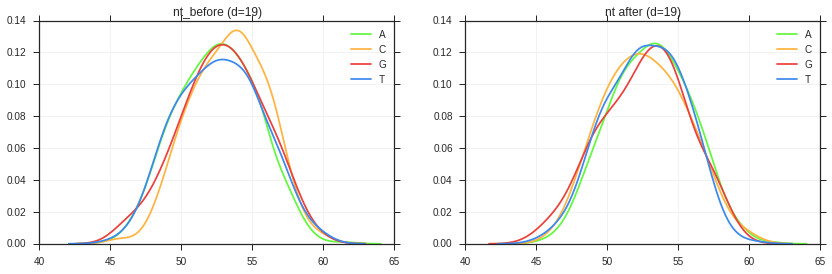

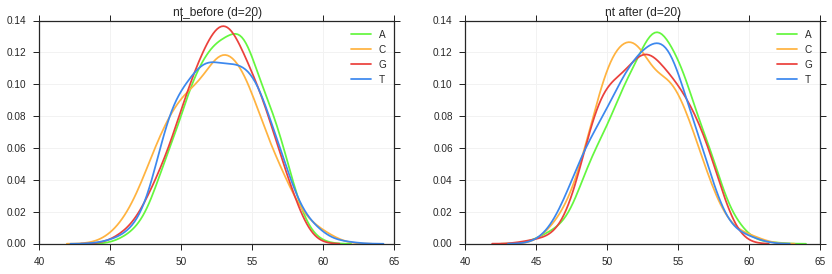

/home/sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


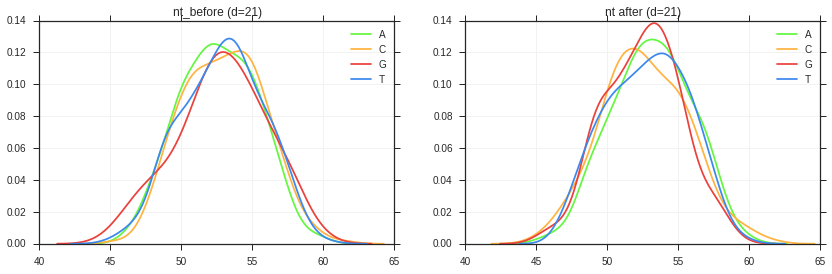

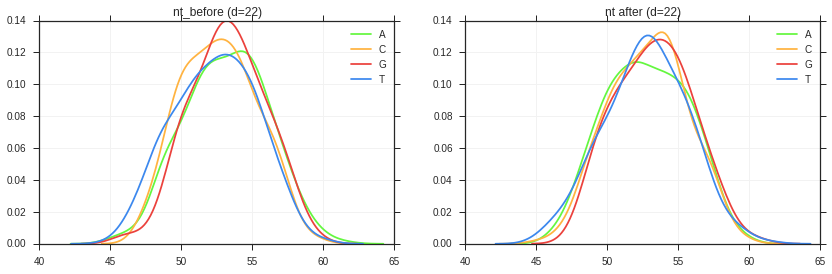

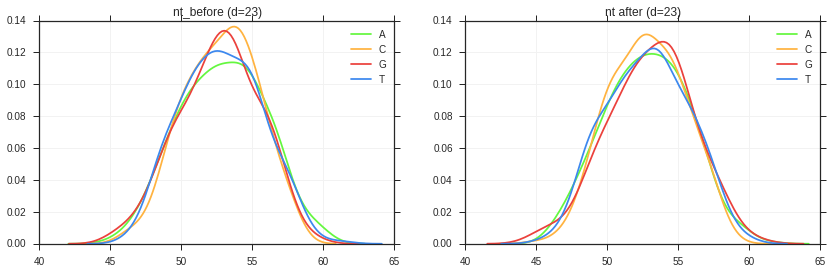

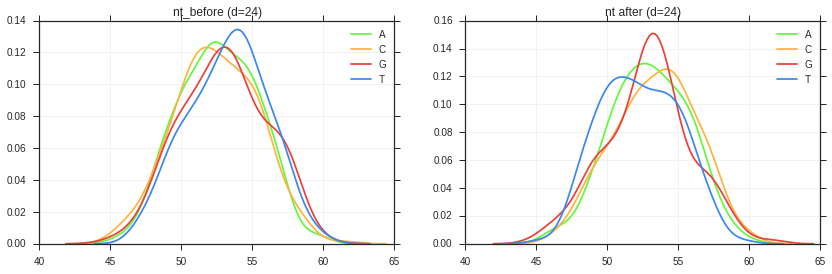

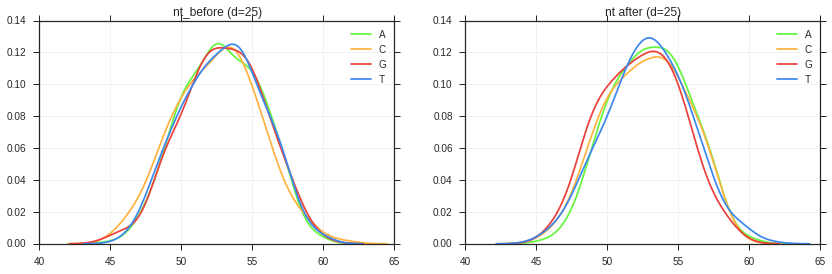

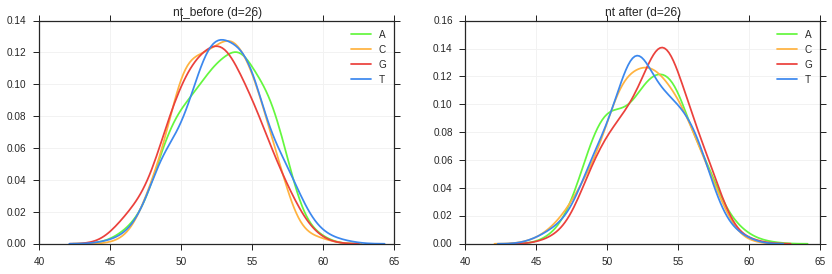

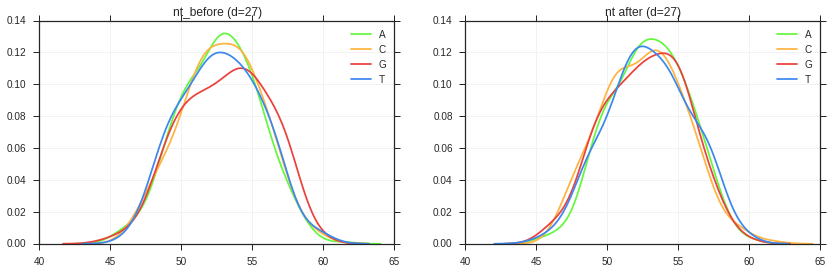

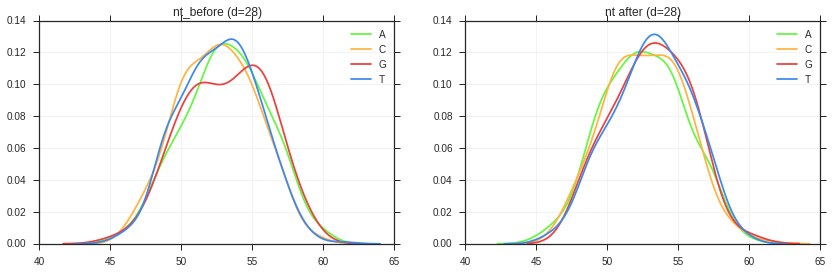

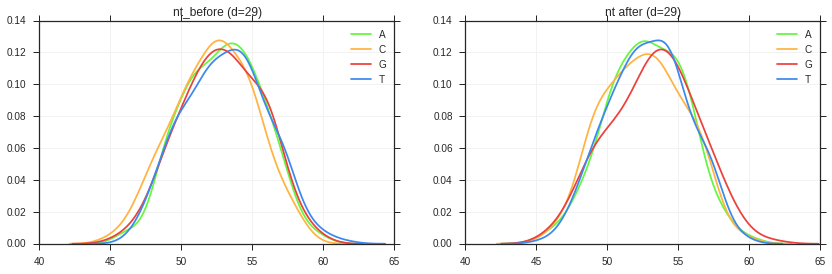

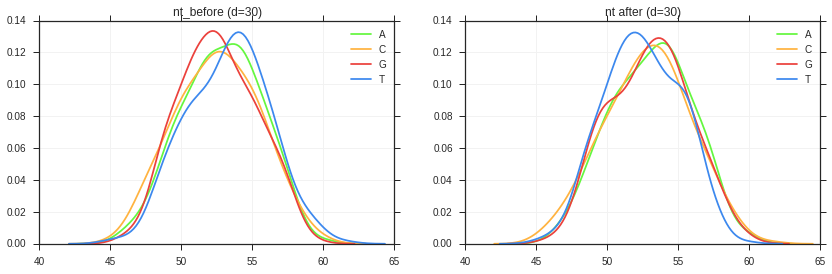

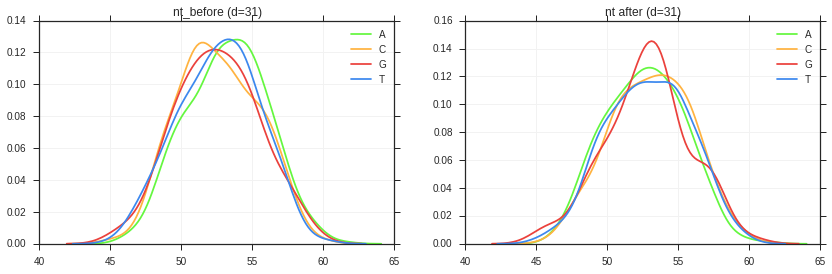

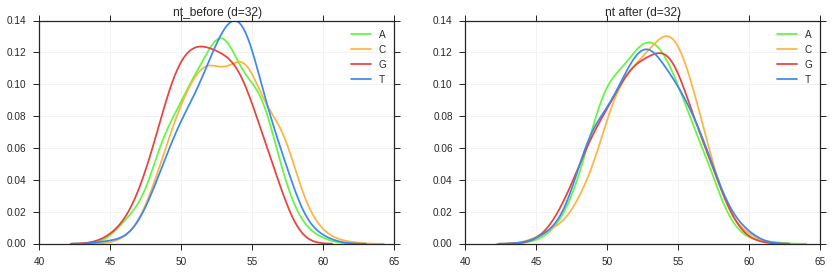

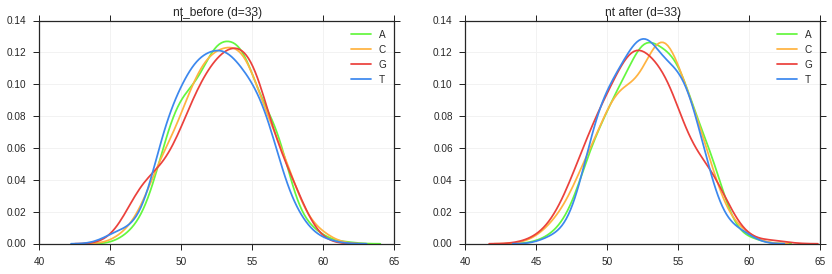

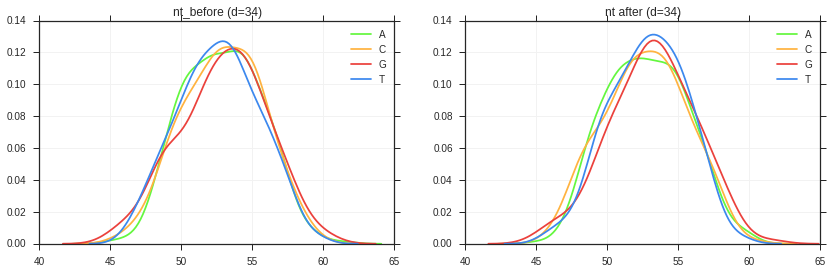

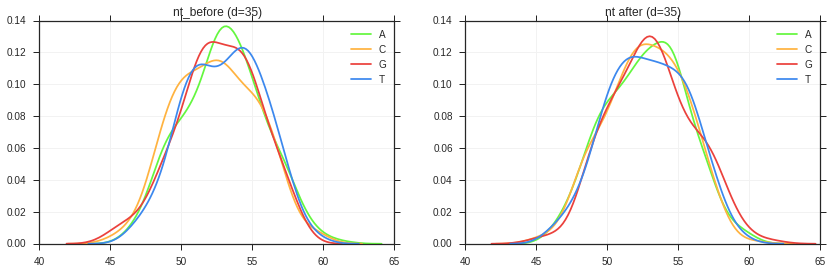

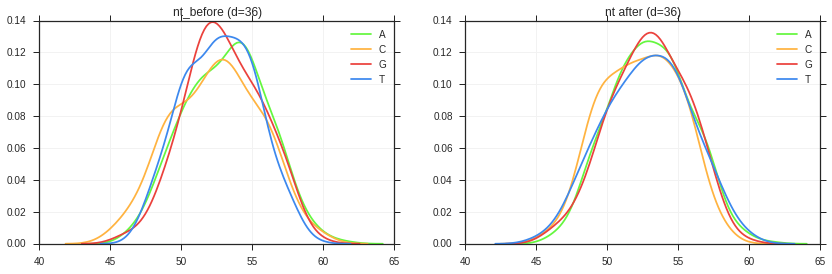

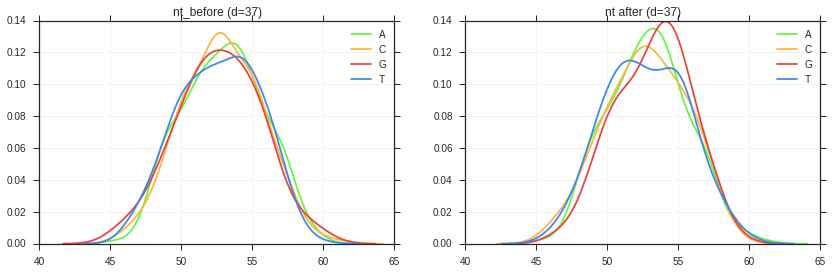

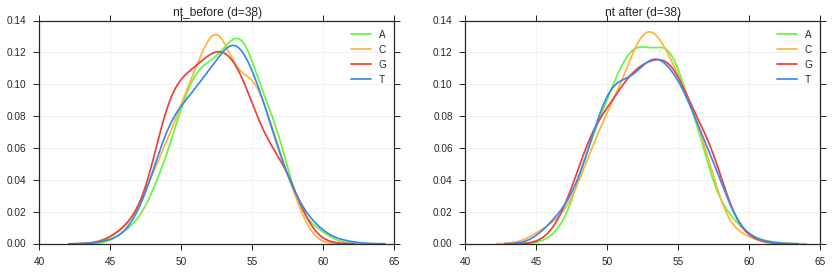

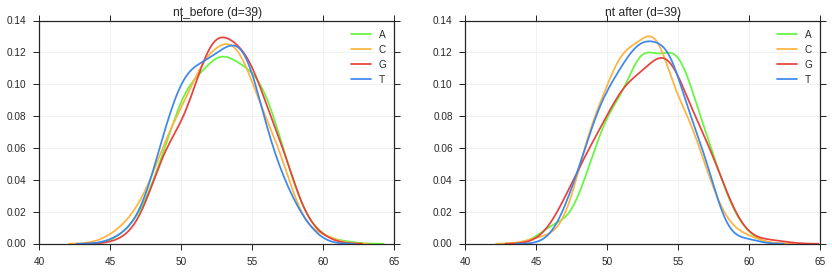

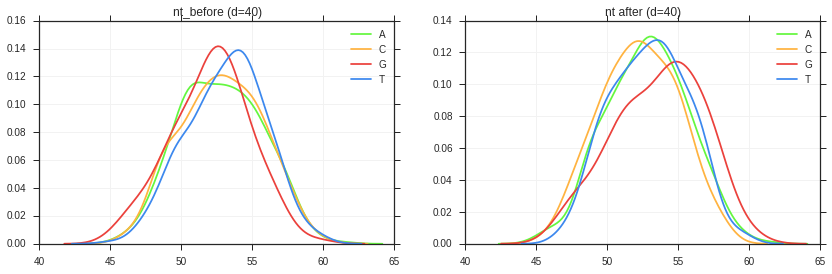

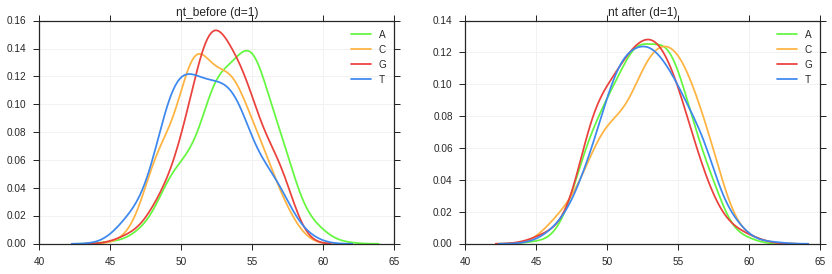

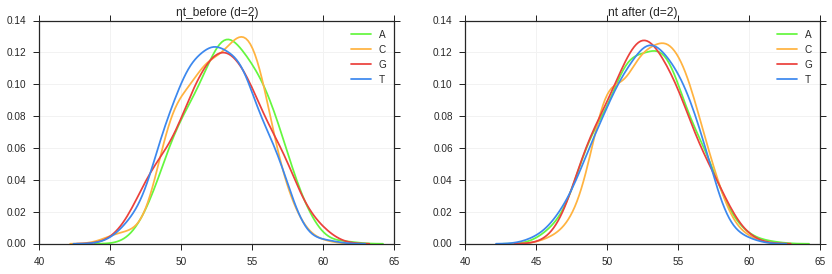

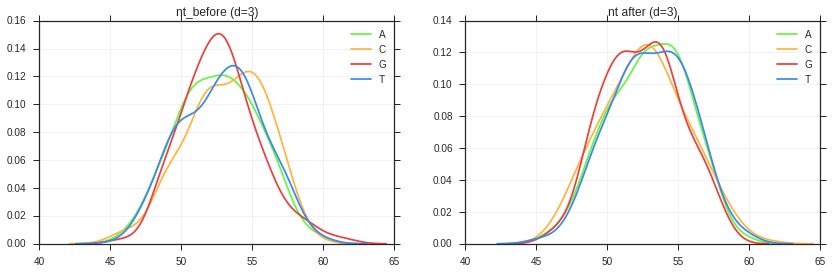

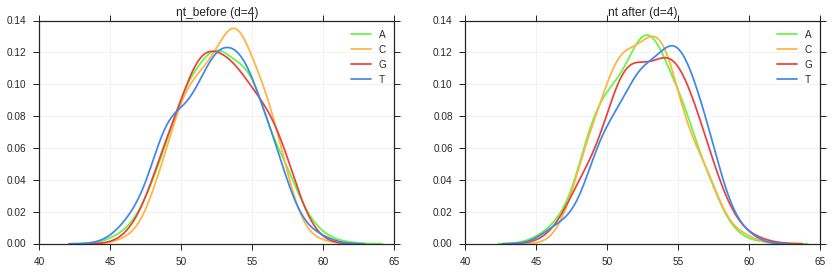

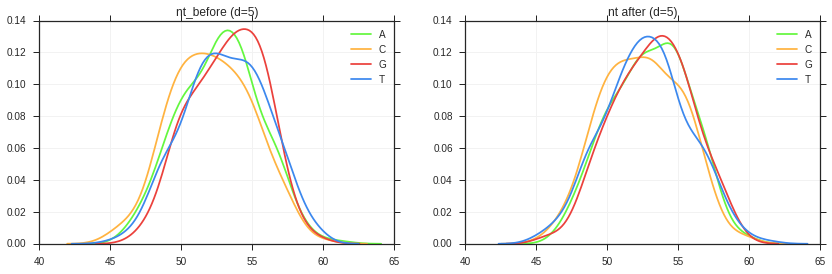

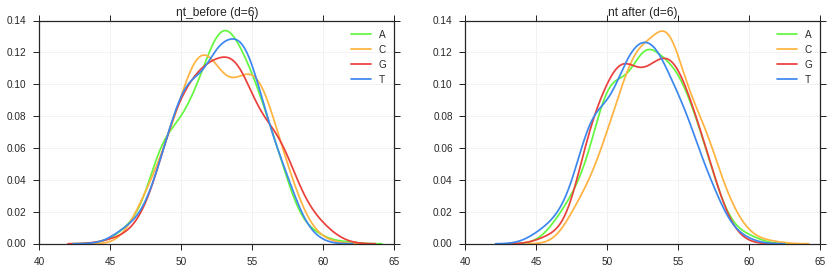

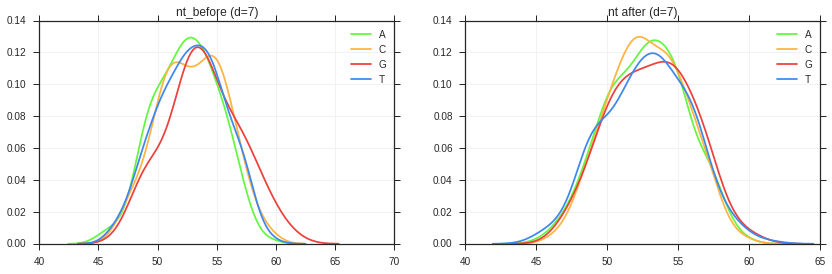

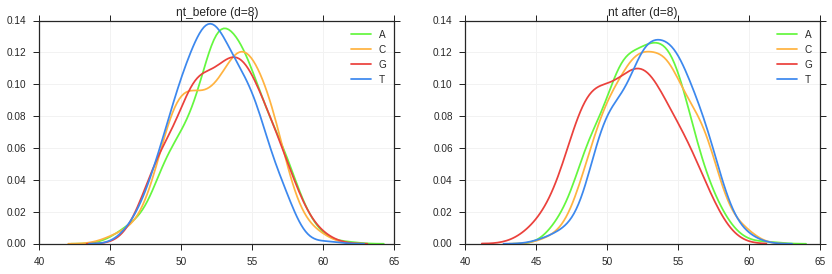

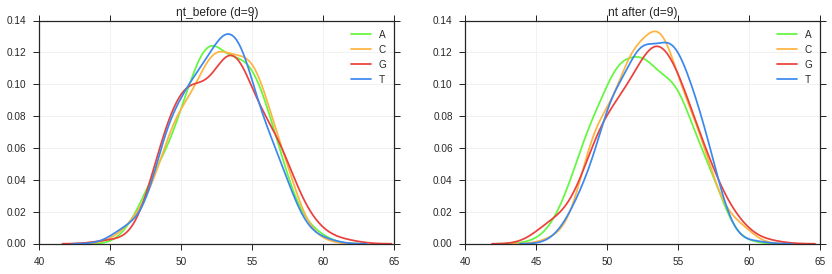

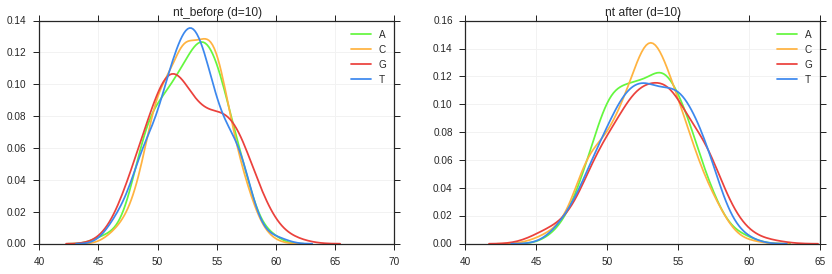

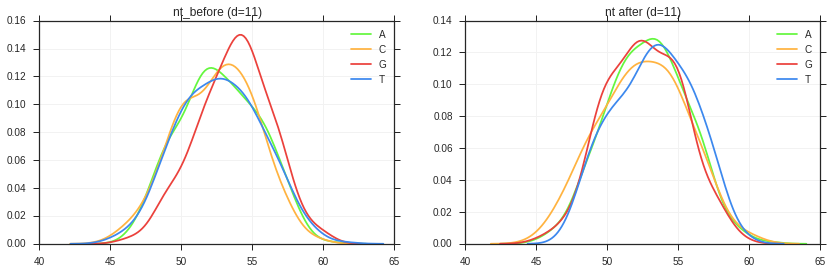

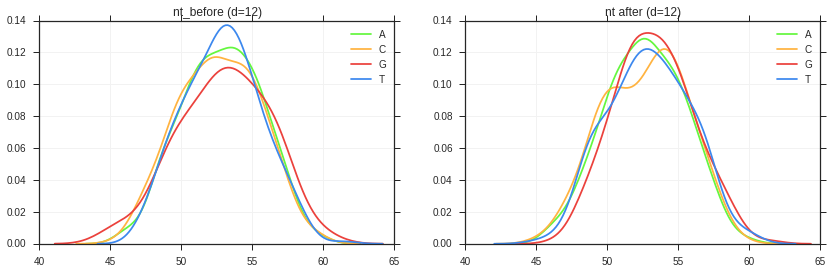

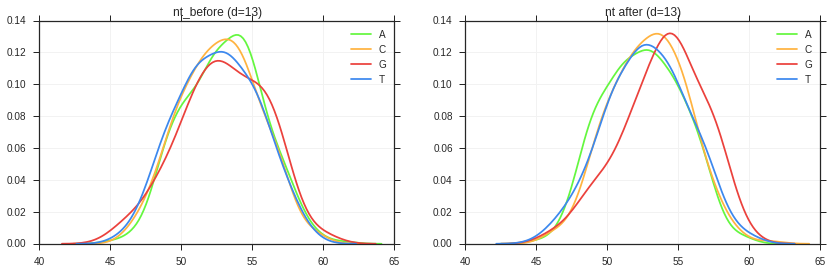

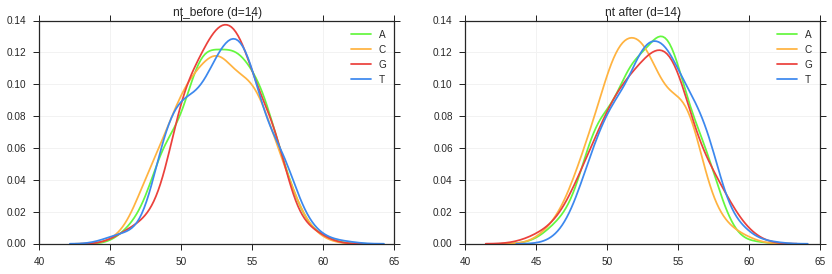

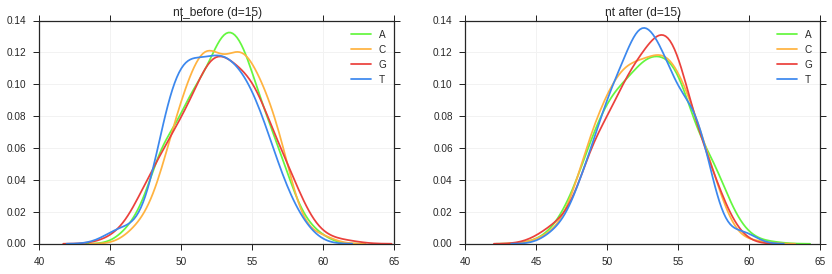

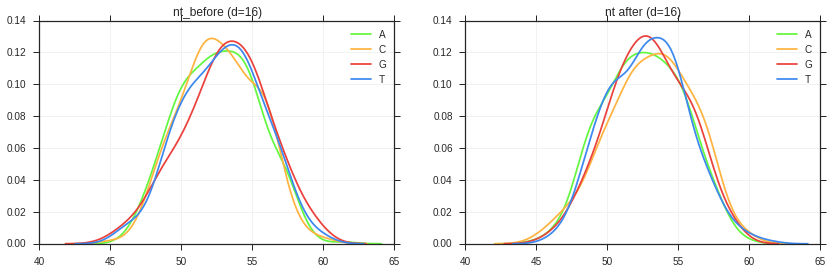

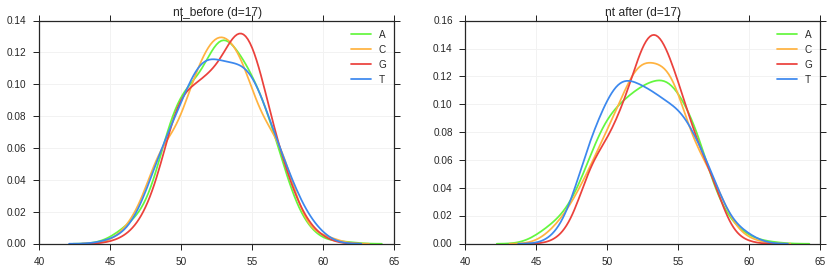

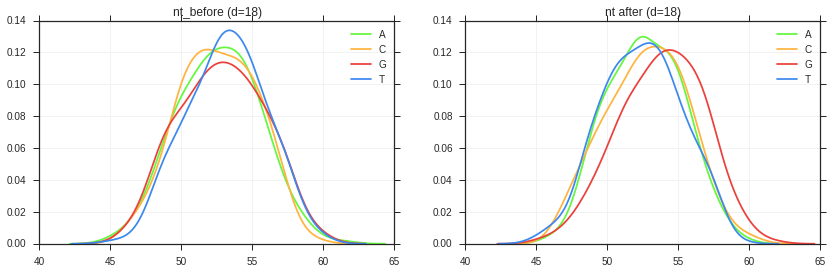

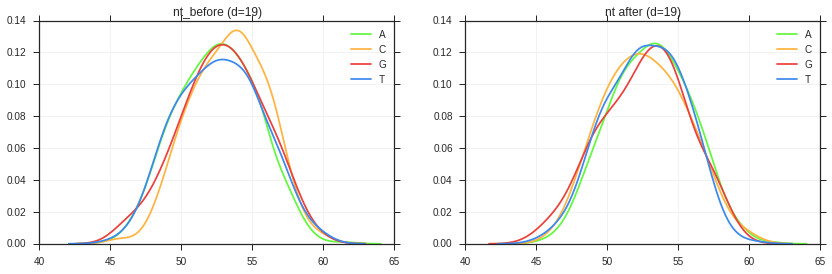

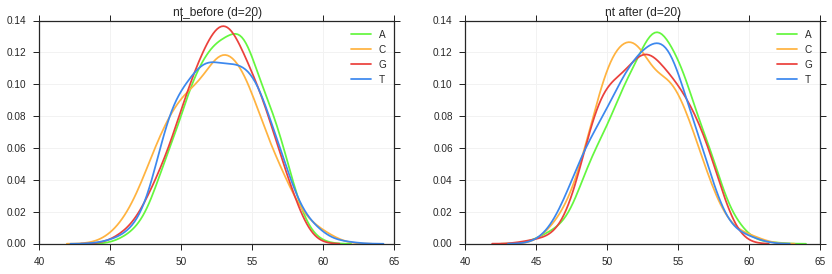

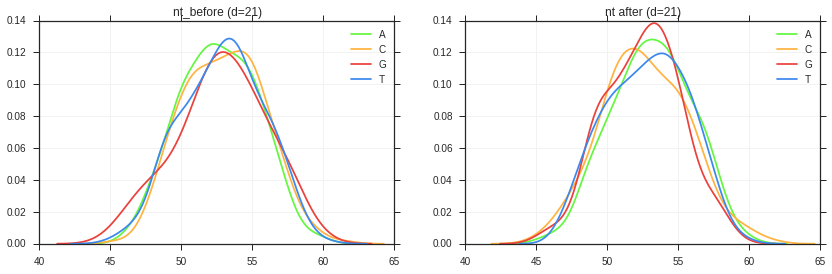

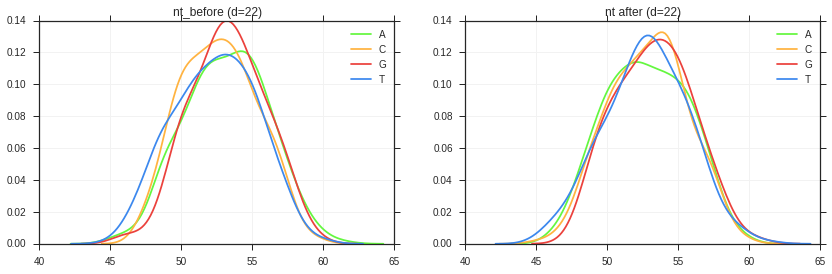

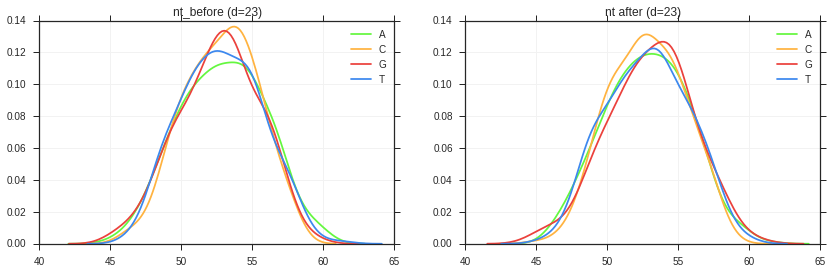

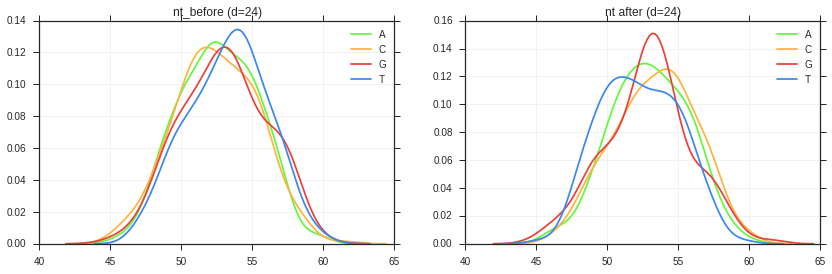

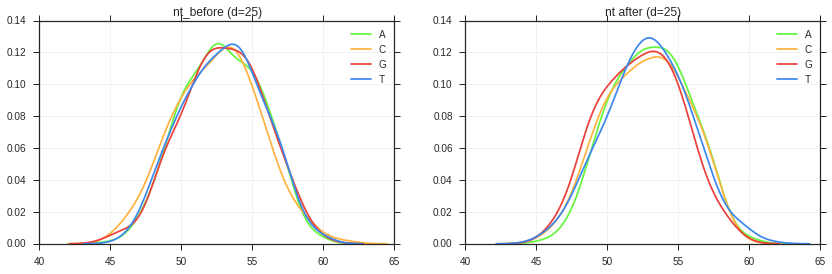

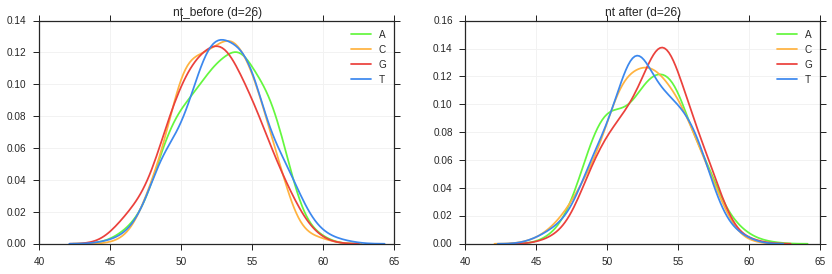

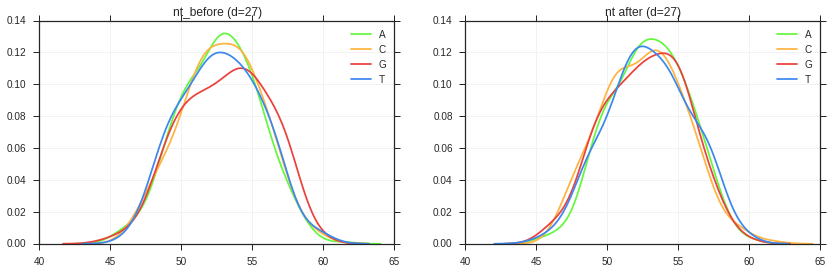

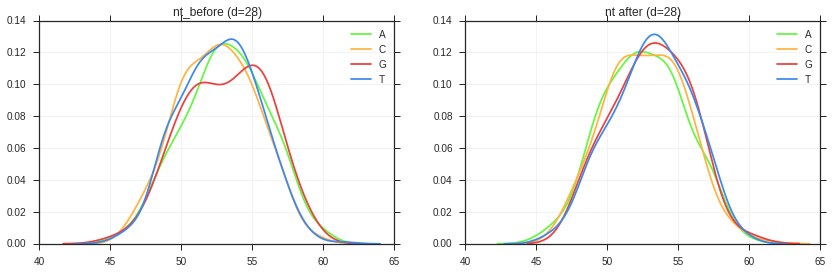

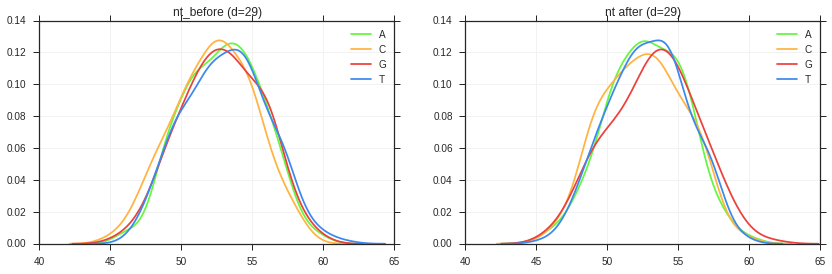

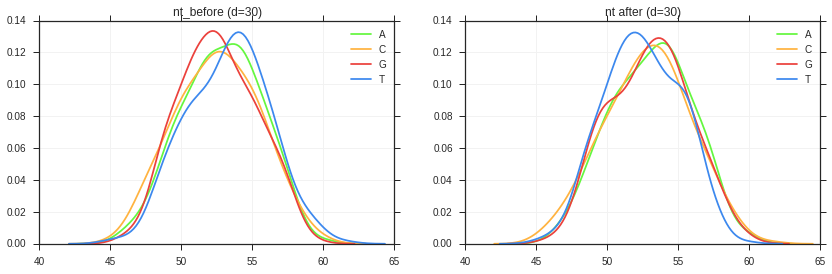

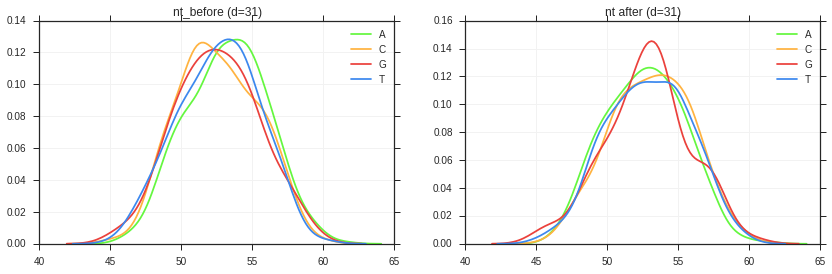

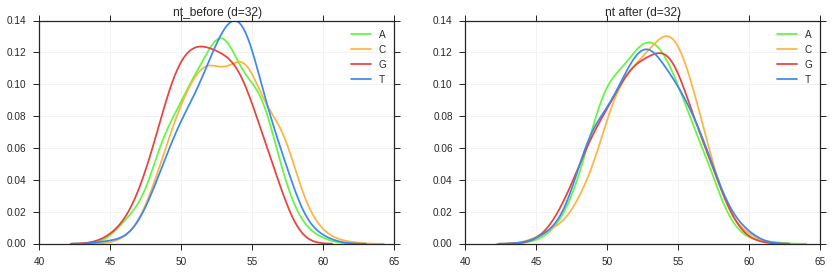

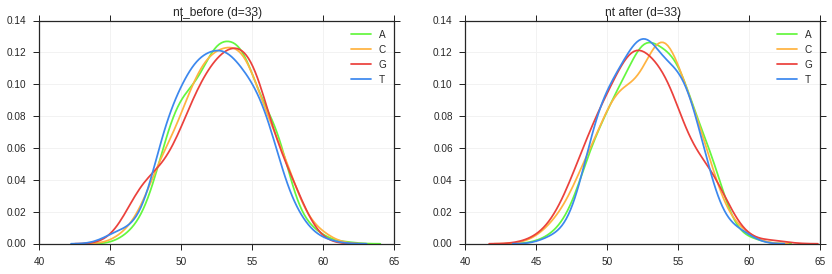

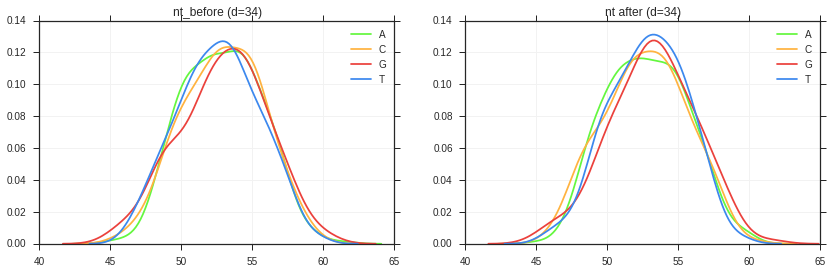

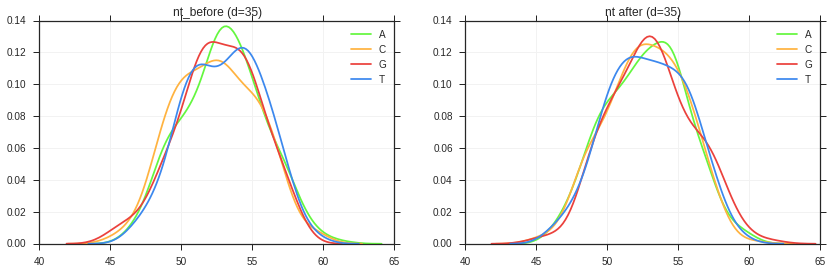

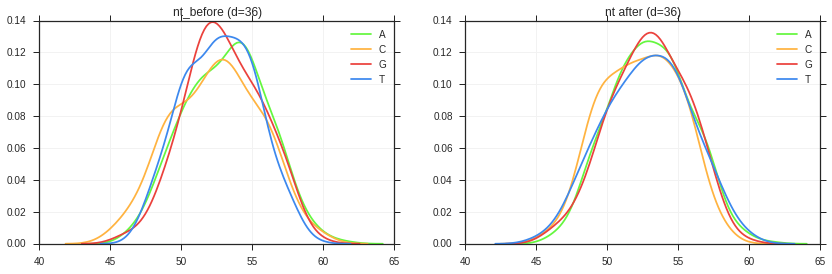

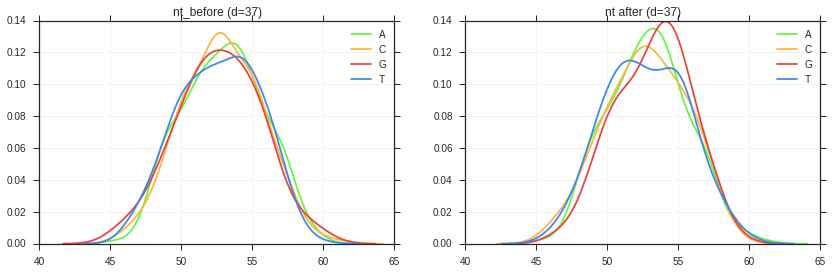

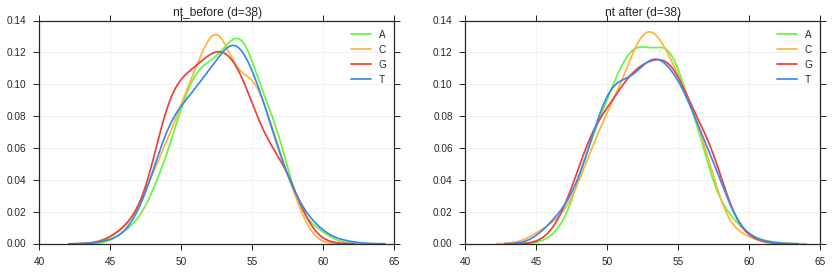

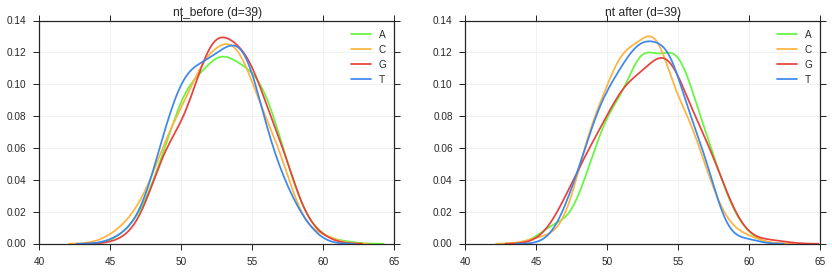

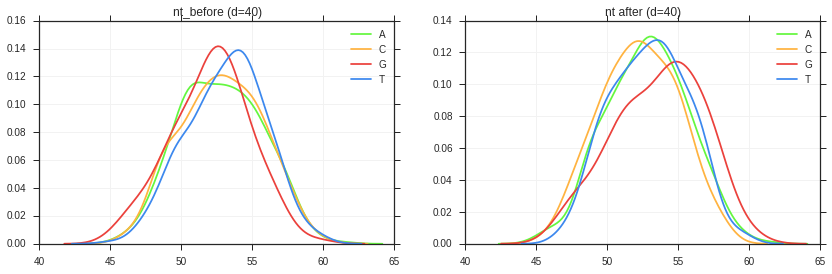

In [163]:
d_means_before = []
for d in range(40):
    nt_before = [NT_MAP[x[-1-d]] for x in context_before]
    nt_after = [NT_MAP[x[0+d]] for x in context_after]
    fig, (ax1, ax2) = subplots(1, 2, figsize=(14,4));
    matrices = []
    for ax, nts, title in [
        (ax1, nt_before, "nt_before (d={0})".format(d+1)),
        (ax2, nt_after, "nt after (d={0})".format(d+1)),]:
            nt_distrib = nt_dict(nts, means)
            d_means.append(nt_distrib)
            matrix = {nt: {} for nt in NT_RMAP.values()}
            for A, B in iterproduct(nt_distrib.items(), repeat=2):
                test = scipy.stats.ttest_ind(A[1], B[1])
                matrix[A[0]][B[0]] = test[1]
            matrices.append(pandas.DataFrame(matrix))
            for nt, nt_mean in nt_distrib.items():
                ax.set_title(title);
                f = sns.distplot(nt_mean, hist=False, label=nt, color=NT_COLORS[nt], ax=ax);
                
    display(side_by_side(*matrices))
    display(fig);  
    


In [172]:
d_means = []
for d in range(200):
    nt_before = [NT_MAP[x[-1-d]] for x in context_before]
    nt_distrib = nt_dict(nt_before, means)
    d_means.append(nt_distrib)

In [173]:
d_means = [{k: np.mean(v) for k, v in d.items()} for d in d_means]

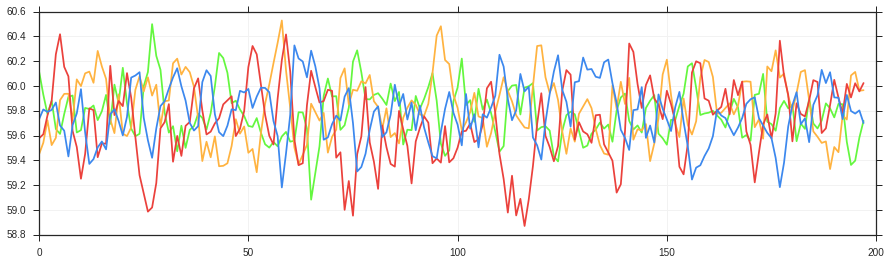

In [175]:
fig, ax = subplots(figsize=(15, 4))
for nt in "ACGT":
    data = [d[nt] for d in d_means]
    data_smoothed = [np.mean((data[i], data[i+1], data[i+2])) for i in range(len(data)-2)]
    ax.plot(range(len(data_smoothed)), data_smoothed, color=NT_COLORS[nt])

In [167]:
d_means = []
for d in range(200):
    nt_before = nt_after = [NT_MAP[x[0+d]] for x in context_after]
    nt_distrib = nt_dict(nt_before, means)
    d_means.append(nt_distrib)

In [168]:
d_means = [{k: np.mean(v) for k, v in d.items()} for d in d_means]

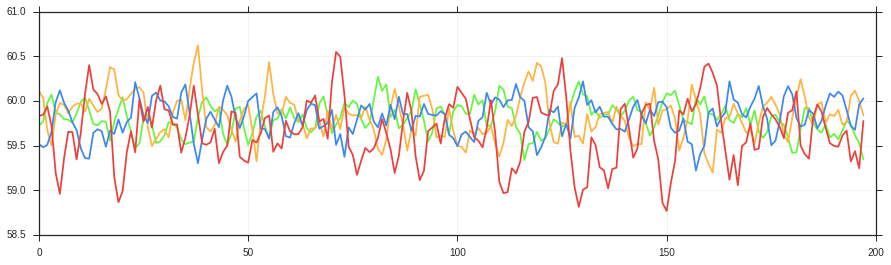

In [159]:
fig, ax = subplots(figsize=(15, 4))
for nt in "ACTG":
    data = [d[nt] for d in d_means]
    data_smoothed = [np.mean((data[i], data[i+1], data[i+2])) for i in range(len(data)-2)]
    ax.plot(range(len(data_smoothed)), data_smoothed, color=NT_COLORS[nt])